In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

## Question 1

## Reading the Dataset:

In [2]:
df=pd.read_csv("adult.csv")
#print(df.head(5))

## Dataset Cleaning and Preprocessing:

In [3]:
df["workclass"].replace(np.NaN, "Private", inplace=True)
df["occupation"].replace(np.NaN, "Missing", inplace=True)
df["native-country"].replace(np.NaN, "United-States", inplace=True)
#df.dropna(how='any',inplace=True)
#df=df.drop_duplicates()
def ordinal_encoding(data) :  
    for j, x in enumerate(data.select_dtypes(exclude=['float64','int64']).columns.to_list()): 
        my_dict = {v:i for i, v in enumerate(data[x].unique(), 0)}

        data.loc[:, x] = data.loc[:, x].map(my_dict)


#df = pd.get_dummies(df, drop_first=True)        
ordinal_encoding(df) 
df
#df.drop(['educational-num','capital-gain','capital-loss'],axis=1)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,0,226802,0,7,0,0,0,0,0,0,0,40,0,0
1,38,0,89814,1,9,1,1,1,1,0,0,0,50,0,0
2,28,1,336951,2,12,1,2,1,1,0,0,0,40,0,1
3,44,0,160323,3,10,1,0,1,0,0,7688,0,40,0,1
4,18,2,103497,3,10,0,3,0,1,1,0,0,30,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,0,257302,2,12,1,9,4,1,1,0,0,38,0,0
48838,40,0,154374,1,9,1,0,1,1,0,0,0,40,0,1
48839,58,0,151910,1,9,2,7,3,1,1,0,0,40,0,0
48840,22,0,201490,1,9,0,7,0,1,0,0,0,20,0,0


## Train-Test Split code:

In [4]:
def train_test_split(df1):
    shuffle_df1 = df1.sample(frac=1)
    train_size = int(0.8 * len(df1))
    df_train = shuffle_df1[:train_size]
    df_test = shuffle_df1[train_size:]
    return df_train,df_test
df_train,df_test=train_test_split(df)
def dataset_split(df):
    X = df.drop([df.columns[-1]], axis = 1)
    y = df[df.columns[-1]]
    return X, y
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
print(type(X_train),len(X_train))

<class 'pandas.core.frame.DataFrame'> 39073


## 2.1 Implementation of Decision Tree Algorithm:

In [5]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = np.bincount(y)
        most_common=0
        p=0
        for i in range(len(counter)):
          if counter[i]>p:
            most_common=i
            p=counter[i]
            #most_common = counter.most_common(1)[0]
        return most_common

## Code for Checking Accuracy:

In [6]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy
clf = DecisionTree(max_depth=10)
clf.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred = clf.predict(X_test.to_numpy())
acc = accuracy(y_test.to_numpy(), y_pred)

print("Accuracy:", acc)

Accuracy: 0.8535162247927116


## Code for checking RMSE Error:

In [7]:
MSE = np.square(np.subtract(y_test,y_pred)).mean()
print(MSE)

0.14648377520728836


In [8]:
y_pred = clf.predict(X_train.to_numpy())
acc = accuracy(y_train.to_numpy(), y_pred)
MSE = np.square(np.subtract(y_train,y_pred)).mean()
print(MSE)

0.1351316766053285


## Calculting Traning and Validation Error for different Size of the Tree:

In [9]:
train_error,validation_error=[],[]
depth=[2,3,5,7,10]
for i in depth:
    clf = DecisionTree(max_depth=i)
    clf.fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred = clf.predict(X_test.to_numpy())
    validation_error.append(np.square(np.subtract(y_test,y_pred)).mean())
    y_pred = clf.predict(X_train.to_numpy())
    train_error.append(np.square(np.subtract(y_train,y_pred)).mean())

## Ploting the training error and validation error against the different size of the decision tree:

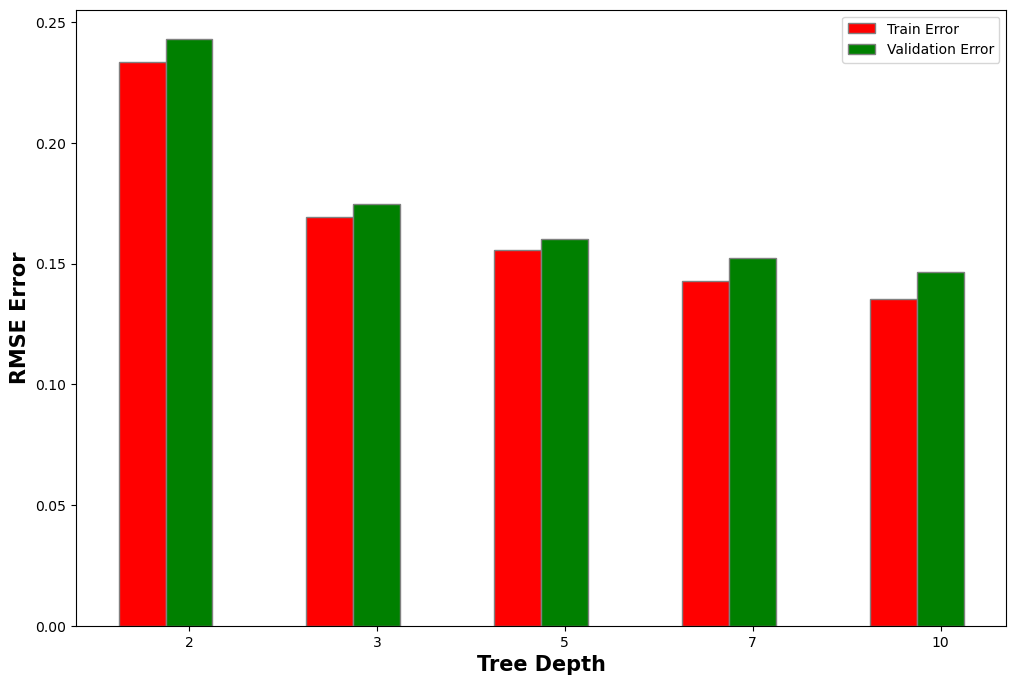

In [10]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(train_error))
br2 = [x + barWidth for x in br1]
plt.bar(br1, train_error, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Error')
plt.bar(br2, validation_error, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Error')
plt.xlabel('Tree Depth', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE Error', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_error))],
        ['2', '3', '5', '7', '10'])
 
plt.legend()
plt.show()

### Storing optimal traning and validation error:

In [11]:
print(train_error)
print(validation_error)
Q1_optimal_error=[train_error[4],validation_error[4]]

[0.23330688710874517, 0.169503237529752, 0.15547820745783533, 0.14270724029380902, 0.1351316766053285]
[0.24301361449483058, 0.17483877571911147, 0.16020063466066128, 0.1522161940833248, 0.146381410584502]


### Comment: From above graph plot against size of the decision tree we can see that the tree of size (max_depth=7) and (max_depth=10) are showing lowest training and validation error for the given dataset. Although we can go further but the problem will be that trees grow too large and the depth of their leaves exceeds 3 or 4, or when they are aggregated in ensembles with dozens of trees, most of the interpretability value is lost. So keeping that matter in mind tree size of (max_depth=10) is a optimal decision tree for this dataset. 

## Question 2

## Bootstrap Function:

In [12]:
import random
#print(df)
dataset_list=[]
for i in range(10):
  dataset_list.append(random.sample(df.values.tolist(), 4884))
print(len(dataset_list))

10


## 2.1 Dataset Created using Bootstrap Sampling.

In [13]:
d_list=[]
for i in dataset_list:
    d_list.append(pd.DataFrame(i,columns=df.columns))

## 1st Dataset Testing:

In [14]:
df_train,df_test=train_test_split(d_list[0])
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
print(type(X_train),len(X_train))

<class 'pandas.core.frame.DataFrame'> 3907


In [15]:
train_error1,validation_error1=[],[]
depth=[2,3,5,7,10]
for i in depth:
    clf = DecisionTree(max_depth=i)
    clf.fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred = clf.predict(X_test.to_numpy())
    validation_error1.append(np.square(np.subtract(y_test,y_pred)).mean())
    y_pred = clf.predict(X_train.to_numpy())
    train_error1.append(np.square(np.subtract(y_train,y_pred)).mean())

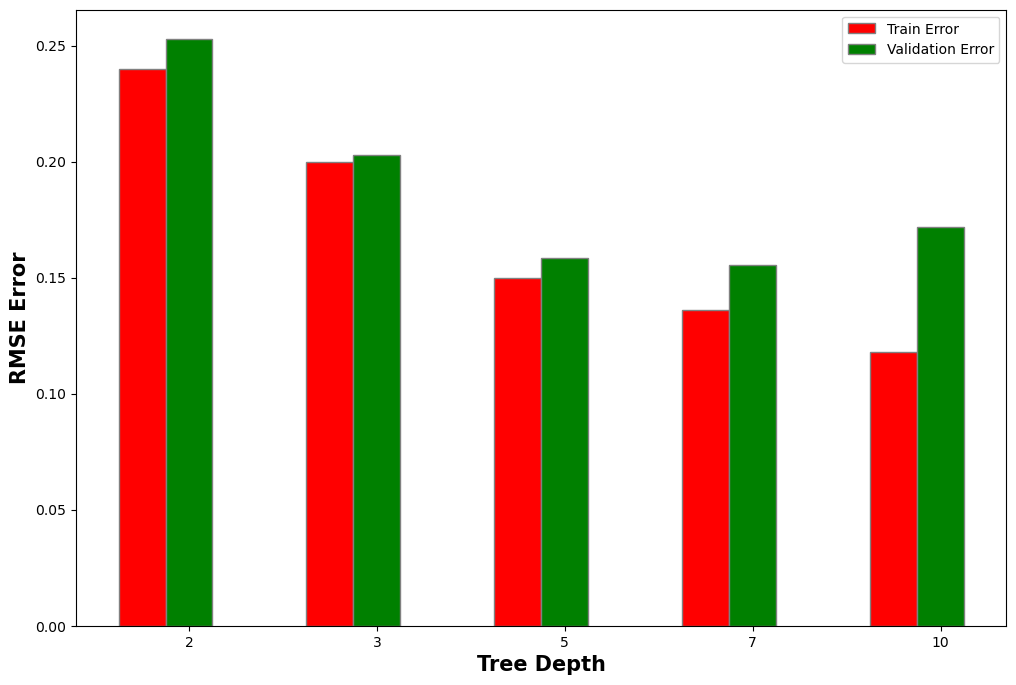

In [16]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(train_error))
br2 = [x + barWidth for x in br1]
plt.bar(br1, train_error1, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Error')
plt.bar(br2, validation_error1, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Error')
plt.xlabel('Tree Depth', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE Error', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_error))],
        ['2', '3', '5', '7', '10'])
 
plt.legend()
plt.show()

## 2nd Dataset Testing:  

In [17]:
df_train,df_test=train_test_split(d_list[1])
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
#print(type(X_train),len(X_train))

In [18]:
train_error2,validation_error2=[],[]
depth=[2,3,5,7,10]
for i in depth:
    clf = DecisionTree(max_depth=i)
    clf.fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred = clf.predict(X_test.to_numpy())
    validation_error2.append(np.square(np.subtract(y_test,y_pred)).mean())
    y_pred = clf.predict(X_train.to_numpy())
    train_error2.append(np.square(np.subtract(y_train,y_pred)).mean())

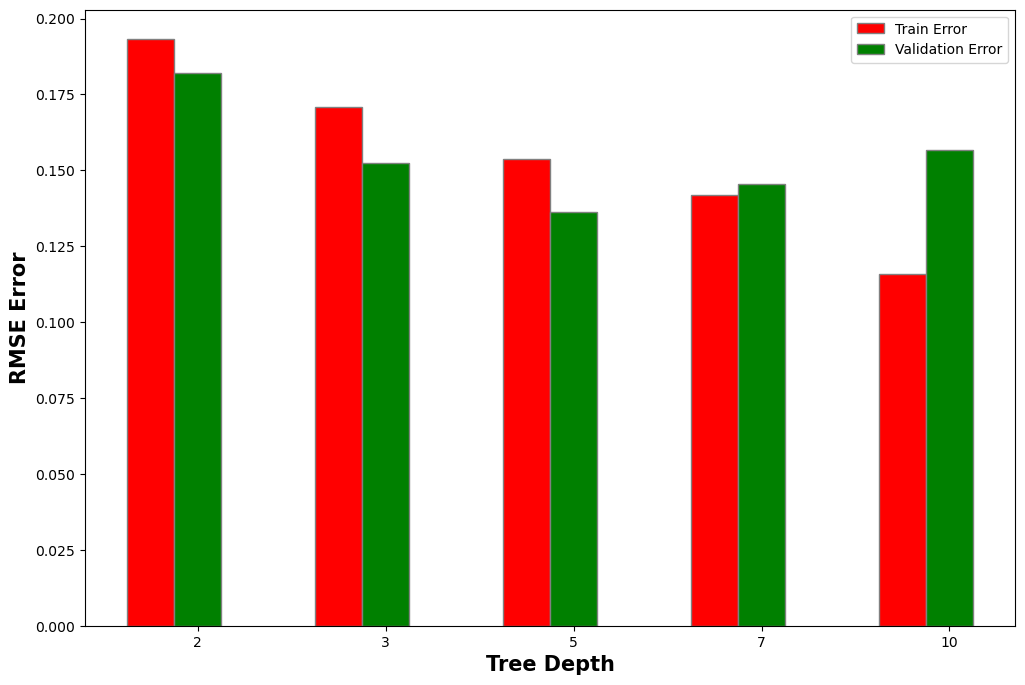

In [19]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(train_error))
br2 = [x + barWidth for x in br1]
plt.bar(br1, train_error2, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Error')
plt.bar(br2, validation_error2, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Error')
plt.xlabel('Tree Depth', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE Error', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_error))],
        ['2', '3', '5', '7', '10'])
 
plt.legend()
plt.show()

## 3rd Dataset Testing:

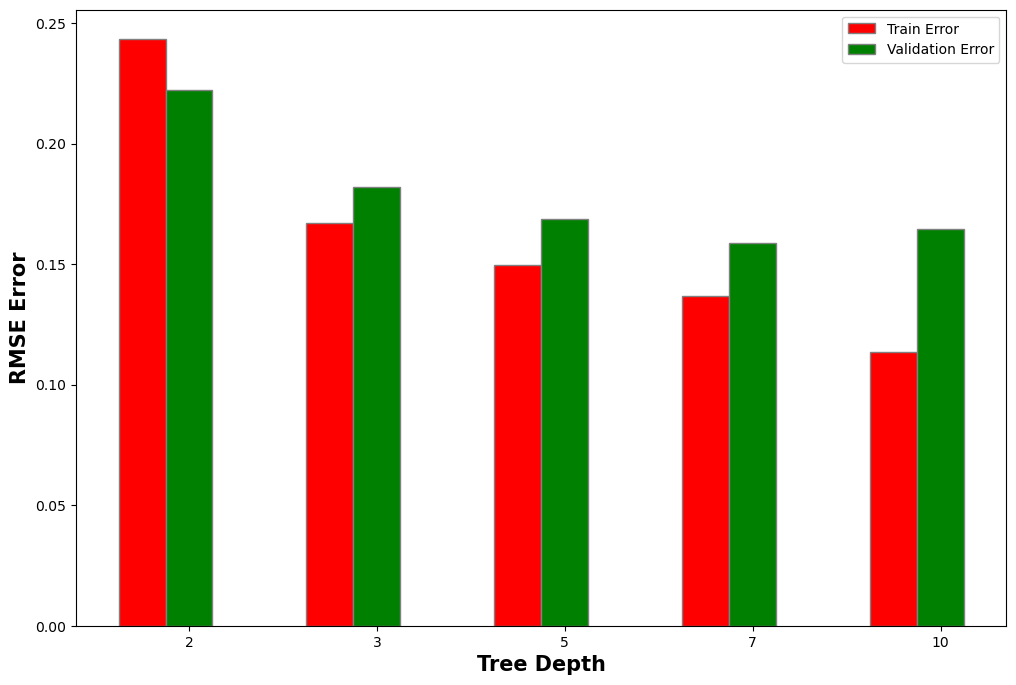

In [20]:
df_train,df_test=train_test_split(d_list[2])
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
#print(type(X_train),len(X_train))
train_error3,validation_error3=[],[]
depth=[2,3,5,7,10]
for i in depth:
    clf = DecisionTree(max_depth=i)
    clf.fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred = clf.predict(X_test.to_numpy())
    validation_error3.append(np.square(np.subtract(y_test,y_pred)).mean())
    y_pred = clf.predict(X_train.to_numpy())
    train_error3.append(np.square(np.subtract(y_train,y_pred)).mean())
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(train_error))
br2 = [x + barWidth for x in br1]
plt.bar(br1, train_error3, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Error')
plt.bar(br2, validation_error3, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Error')
plt.xlabel('Tree Depth', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE Error', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_error))],
        ['2', '3', '5', '7', '10'])
 
plt.legend()
plt.show()

## 4th Dataset Testing:

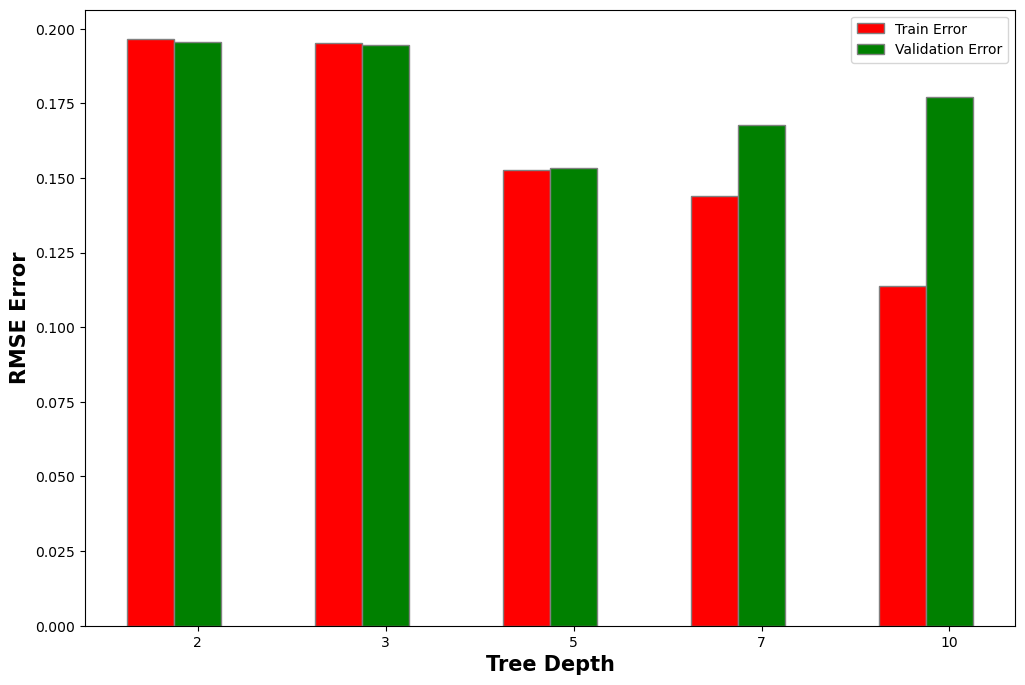

In [21]:
df_train,df_test=train_test_split(d_list[3])
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
#print(type(X_train),len(X_train))
train_error4,validation_error4=[],[]
depth=[2,3,5,7,10]
for i in depth:
    clf = DecisionTree(max_depth=i)
    clf.fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred = clf.predict(X_test.to_numpy())
    validation_error4.append(np.square(np.subtract(y_test,y_pred)).mean())
    y_pred = clf.predict(X_train.to_numpy())
    train_error4.append(np.square(np.subtract(y_train,y_pred)).mean())
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(train_error))
br2 = [x + barWidth for x in br1]
plt.bar(br1, train_error4, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Error')
plt.bar(br2, validation_error4, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Error')
plt.xlabel('Tree Depth', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE Error', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_error))],
        ['2', '3', '5', '7', '10'])
 
plt.legend()
plt.show()

## 5th Dataset Testing:

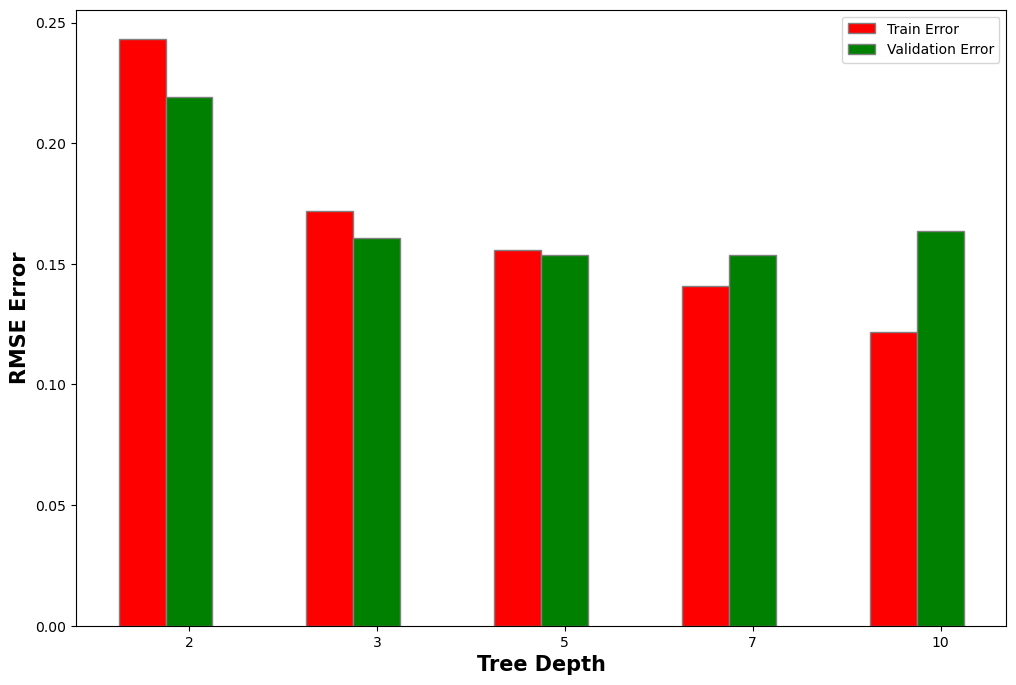

In [22]:
df_train,df_test=train_test_split(d_list[4])
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
#print(type(X_train),len(X_train))
train_error5,validation_error5=[],[]
depth=[2,3,5,7,10]
for i in depth:
    clf = DecisionTree(max_depth=i)
    clf.fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred = clf.predict(X_test.to_numpy())
    validation_error5.append(np.square(np.subtract(y_test,y_pred)).mean())
    y_pred = clf.predict(X_train.to_numpy())
    train_error5.append(np.square(np.subtract(y_train,y_pred)).mean())
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(train_error))
br2 = [x + barWidth for x in br1]
plt.bar(br1, train_error5, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Error')
plt.bar(br2, validation_error5, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Error')
plt.xlabel('Tree Depth', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE Error', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_error))],
        ['2', '3', '5', '7', '10'])
 
plt.legend()
plt.show()

## 6th Dataset Testing:

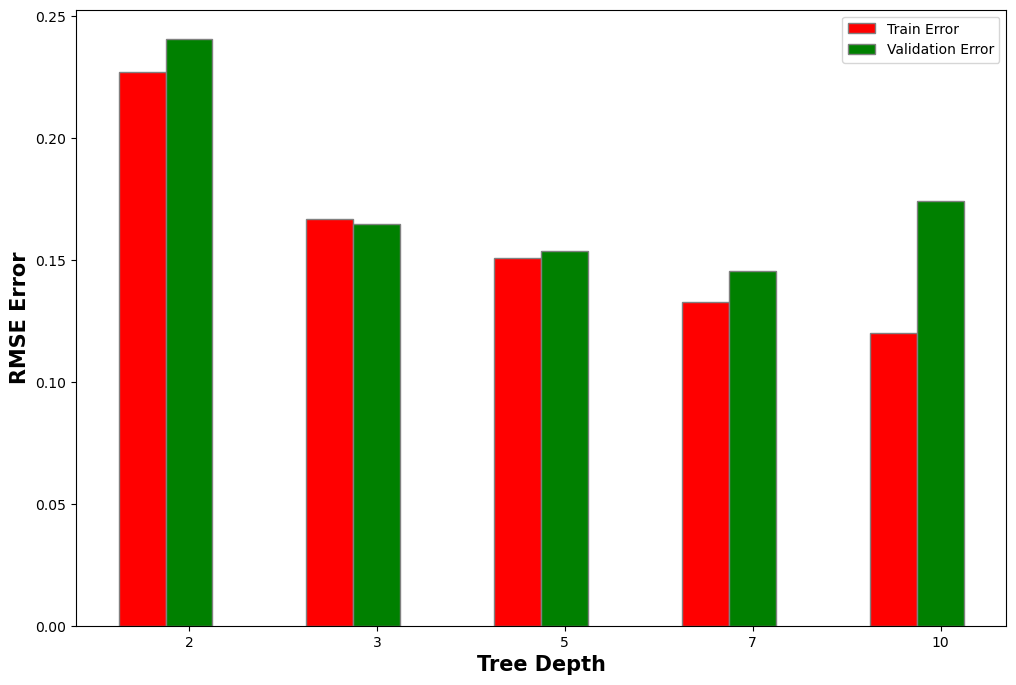

In [23]:
df_train,df_test=train_test_split(d_list[5])
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
#print(type(X_train),len(X_train))
train_error6,validation_error6=[],[]
depth=[2,3,5,7,10]
for i in depth:
    clf = DecisionTree(max_depth=i)
    clf.fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred = clf.predict(X_test.to_numpy())
    validation_error6.append(np.square(np.subtract(y_test,y_pred)).mean())
    y_pred = clf.predict(X_train.to_numpy())
    train_error6.append(np.square(np.subtract(y_train,y_pred)).mean())
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(train_error))
br2 = [x + barWidth for x in br1]
plt.bar(br1, train_error6, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Error')
plt.bar(br2, validation_error6, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Error')
plt.xlabel('Tree Depth', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE Error', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_error))],
        ['2', '3', '5', '7', '10'])
 
plt.legend()
plt.show()

## 7th Dataset Testing:

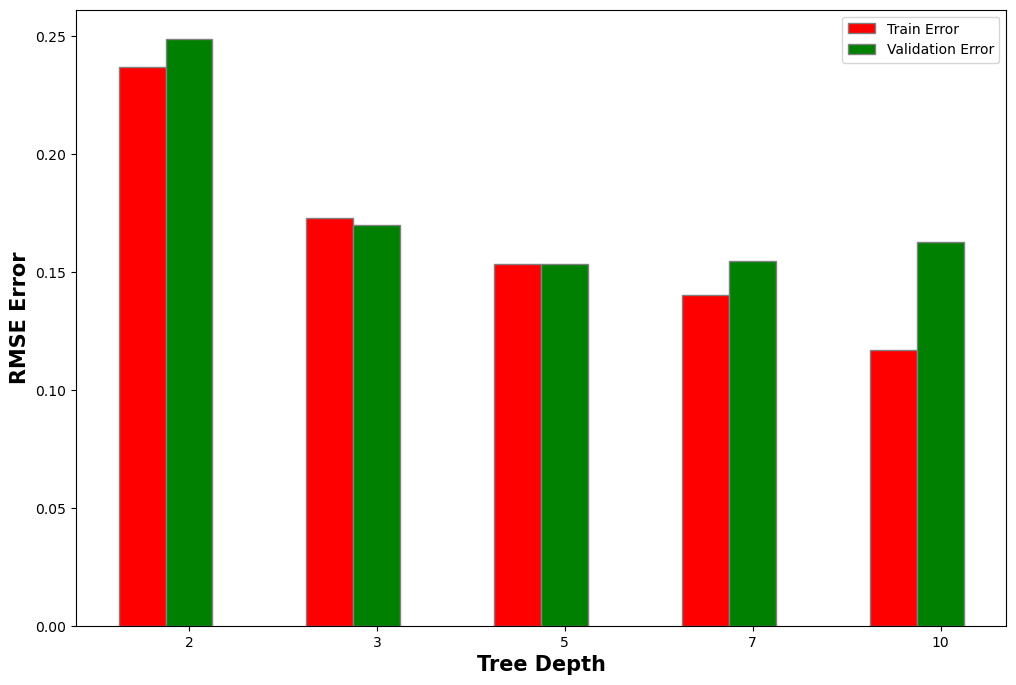

In [24]:
df_train,df_test=train_test_split(d_list[6])
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
#print(type(X_train),len(X_train))
train_error7,validation_error7=[],[]
depth=[2,3,5,7,10]
for i in depth:
    clf = DecisionTree(max_depth=i)
    clf.fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred = clf.predict(X_test.to_numpy())
    validation_error7.append(np.square(np.subtract(y_test,y_pred)).mean())
    y_pred = clf.predict(X_train.to_numpy())
    train_error7.append(np.square(np.subtract(y_train,y_pred)).mean())
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(train_error))
br2 = [x + barWidth for x in br1]
plt.bar(br1, train_error7, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Error')
plt.bar(br2, validation_error7, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Error')
plt.xlabel('Tree Depth', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE Error', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_error))],
        ['2', '3', '5', '7', '10'])
 
plt.legend()
plt.show()

## 8th Dataset Testing:

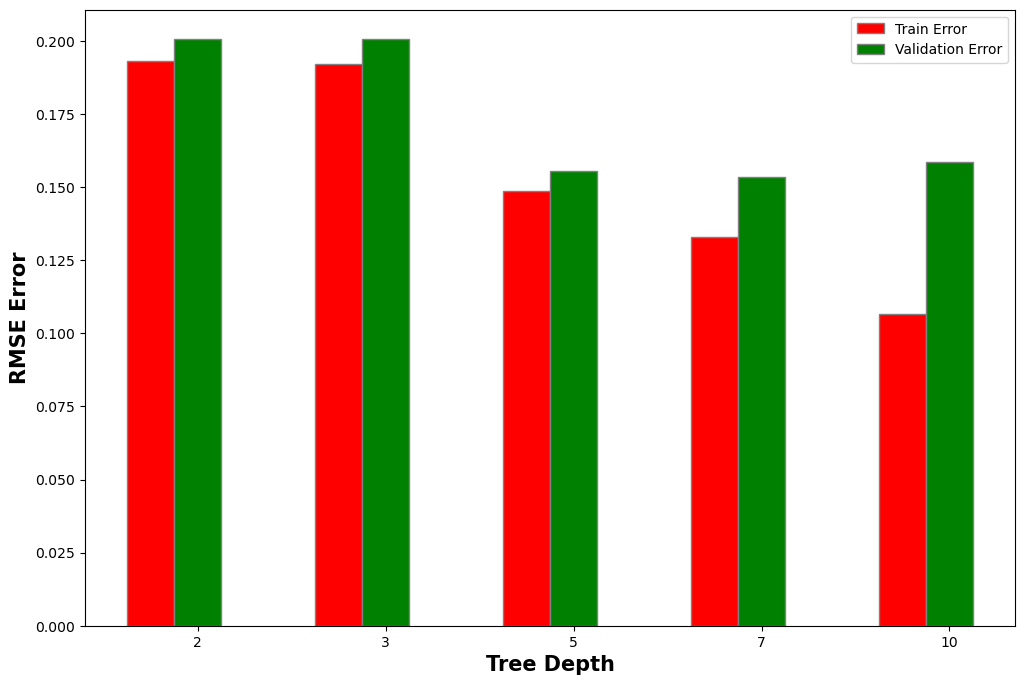

In [25]:
df_train,df_test=train_test_split(d_list[7])
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
#print(type(X_train),len(X_train))
train_error8,validation_error8=[],[]
depth=[2,3,5,7,10]
for i in depth:
    clf = DecisionTree(max_depth=i)
    clf.fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred = clf.predict(X_test.to_numpy())
    validation_error8.append(np.square(np.subtract(y_test,y_pred)).mean())
    y_pred = clf.predict(X_train.to_numpy())
    train_error8.append(np.square(np.subtract(y_train,y_pred)).mean())
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(train_error))
br2 = [x + barWidth for x in br1]
plt.bar(br1, train_error8, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Error')
plt.bar(br2, validation_error8, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Error')
plt.xlabel('Tree Depth', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE Error', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_error))],
        ['2', '3', '5', '7', '10'])
 
plt.legend()
plt.show()

## 9th Dataset Testing:

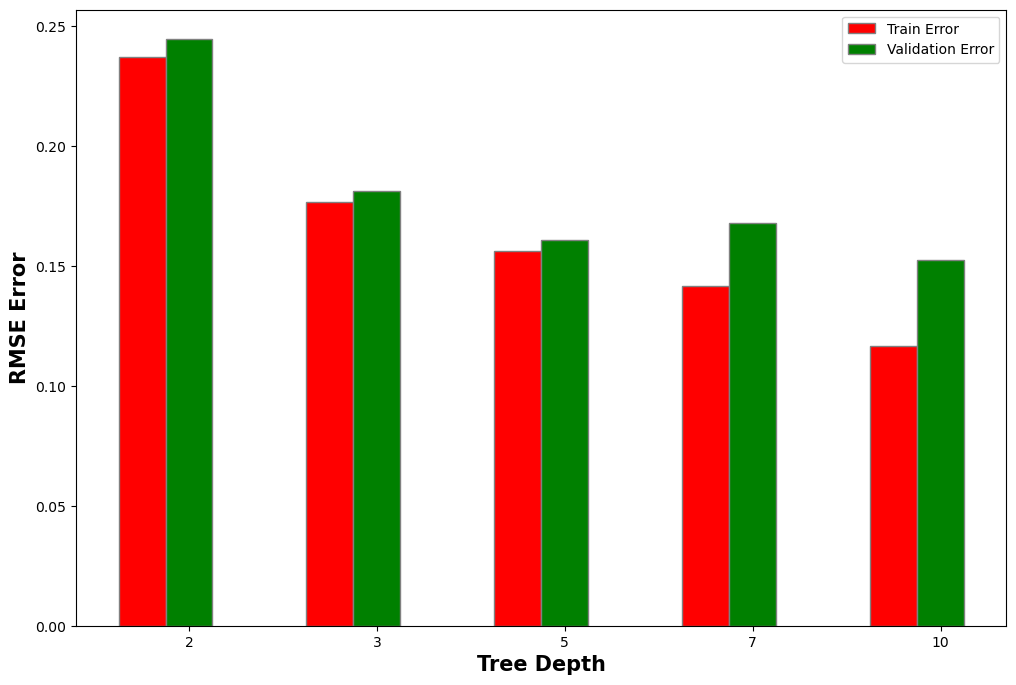

In [26]:
df_train,df_test=train_test_split(d_list[8])
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
#print(type(X_train),len(X_train))
train_error9,validation_error9=[],[]
depth=[2,3,5,7,10]
for i in depth:
    clf = DecisionTree(max_depth=i)
    clf.fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred = clf.predict(X_test.to_numpy())
    validation_error9.append(np.square(np.subtract(y_test,y_pred)).mean())
    y_pred = clf.predict(X_train.to_numpy())
    train_error9.append(np.square(np.subtract(y_train,y_pred)).mean())
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(train_error))
br2 = [x + barWidth for x in br1]
plt.bar(br1, train_error9, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Error')
plt.bar(br2, validation_error9, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Error')
plt.xlabel('Tree Depth', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE Error', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_error))],
        ['2', '3', '5', '7', '10'])
 
plt.legend()
plt.show()

## 10th Dataset Testing:

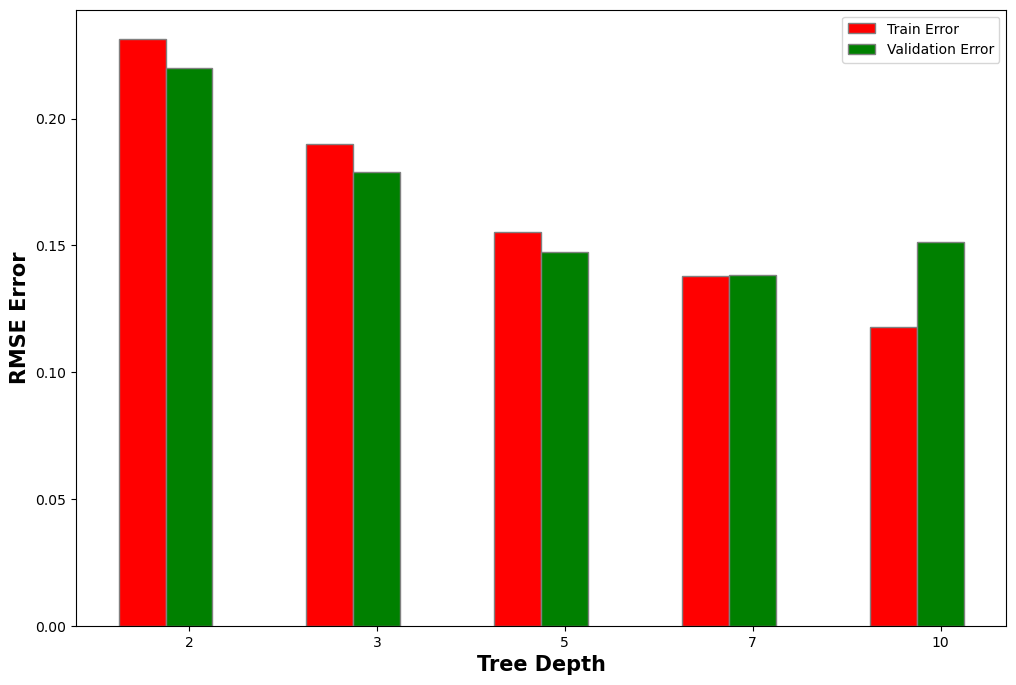

In [27]:
df_train,df_test=train_test_split(d_list[9])
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
#print(type(X_train),len(X_train))
train_error10,validation_error10=[],[]
depth=[2,3,5,7,10]
for i in depth:
    clf = DecisionTree(max_depth=i)
    clf.fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred = clf.predict(X_test.to_numpy())
    validation_error10.append(np.square(np.subtract(y_test,y_pred)).mean())
    y_pred = clf.predict(X_train.to_numpy())
    train_error10.append(np.square(np.subtract(y_train,y_pred)).mean())
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(train_error))
br2 = [x + barWidth for x in br1]
plt.bar(br1, train_error10, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Error')
plt.bar(br2, validation_error10, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Error')
plt.xlabel('Tree Depth', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE Error', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_error))],
        ['2', '3', '5', '7', '10'])
 
plt.legend()
plt.show()

## Final average training and validation error using Bootstrap samplled datasets.

In [28]:
avg_validation_error=(validation_error1[2]+validation_error2[3]+validation_error3[3]+validation_error4[2]+validation_error5[3]+validation_error6[2]+validation_error7[2]+validation_error8[3]+validation_error9[3]+validation_error10[3])/10
avg_train_error=(train_error1[2]+train_error2[3]+train_error3[3]+train_error4[2]+train_error5[3]+train_error6[2]+train_error7[2]+train_error8[3]+train_error9[3]+train_error10[3])/10
print("Question 1 train error: ",Q1_optimal_error[0])
print("Question 2 average train error: ",avg_train_error)
print("Question 1 validation error: ",Q1_optimal_error[1])
print("Question 2 average validation error: ",avg_validation_error)

Question 1 train error:  0.1351316766053285
Question 2 average train error:  0.14389557205016637
Question 1 validation error:  0.146381410584502
Question 2 average validation error:  0.15363357215967247


### Comment:  From the above observation we can tell that we have achieved almost similar error compared to previous question's optimal decision tree. Note that in the previous question decision tree we had achieved the result at a large tree size of (max_depth=10) but in this question we have achieved the result in coparatively small tree size which means that small size tree on rather small dataset creates better result when we averaging the error of each of the optimal decision tree of each dataset.

## Question 3:

In [29]:
target_df = pd.DataFrame([], columns=['income'])
target_df['income'] = df["income"]
data = df.drop('income', axis=1)

## Function to normalized data:

In [30]:
def standardScaler(data):
    '''axis=0 means along the column, axis=1 means working along the row.'''
    scaled_df = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
    return scaled_df

scaled_df = standardScaler(data)
scaled_df = np.around(scaled_df, 3)

## 3.1 Calculating optimal number of features for the dataset:

In [31]:
def computeCovarianceMatrix(data):
    len_data = data.shape[0]
    covariance = data.T.dot(data)/len_data
    return covariance

cov_mat = computeCovarianceMatrix(scaled_df)   # or scaled_df.cov()
cov_mat = np.around(cov_mat,3)

In [32]:
eig_values, eig_vectors = np.linalg.eig(cov_mat)
print('\nNumber of Eigenvectors : %s ' %len(eig_vectors))
print('\nEigenvectors : \n\n%s' %eig_vectors)
print('\nEigenvalues : \n\n%s' %eig_values)


Number of Eigenvectors : 14 

Eigenvectors : 

[[ 2.49177709e-01  4.56023957e-01  4.06681604e-01 -4.82826783e-01
  -7.59053282e-02 -3.57272683e-01  1.56821354e-01  2.86618929e-02
   2.73958826e-01 -2.65460076e-01  1.35879248e-01  3.61961102e-02
  -8.31642113e-02 -2.02251226e-02]
 [-4.59663364e-02  3.59941508e-01 -6.91353728e-02  1.72904061e-01
   2.33429489e-01 -1.00273268e-01  6.82265603e-02 -8.21457457e-03
  -6.53036436e-01 -3.19604681e-01  8.10484580e-03  4.76289825e-01
  -5.41607969e-02 -7.70225839e-02]
 [-3.06240083e-02 -1.33521388e-01  1.04663432e-01 -6.27900154e-02
  -6.86132072e-02 -1.04437908e-01 -4.30050822e-01  4.93384930e-01
  -2.03247579e-01 -1.08294368e-01 -8.48108234e-02 -1.90160811e-01
  -6.45612794e-01  9.56169639e-02]
 [-5.94208343e-02  3.43607773e-01  4.11359993e-03  2.08743726e-01
   4.66487294e-01  4.58029670e-01 -1.82909060e-01  6.30242918e-02
   3.84159448e-01 -4.28861002e-03  4.03562768e-01  3.52527875e-02
  -2.33971863e-01 -5.94749087e-02]
 [-1.34052510e-01  4

In [33]:
eigenvec_df = pd.DataFrame(eig_vectors) 
eigenvec_df.columns = ['eigvec_'+str(i+1) for i in range(0, len(eig_vectors))]

In [34]:
indexes = eig_values.argsort()[::-1]   
eig_values = eig_values[indexes] 
eig_vectors = eig_vectors[:, indexes]
sorted_eig_pairs = [(np.around(np.abs(eig_values[i]),3), eig_vectors[:,i]) for i in range(len(eig_values))]
print('\nSorted Eigen-pairs (descending order) :\n')

sorted_eigenValues = []
for i in range(0, len(sorted_eig_pairs)):
    print("eigenvec_{0} : {1}".format(str(i+1), str(sorted_eig_pairs[i][0])))
    sorted_eigenValues.append(sorted_eig_pairs[i][0])
    
print("\nTotal Variance (sum of all eigenvalues) : ", round(sum(sorted_eigenValues), 3))


Sorted Eigen-pairs (descending order) :

eigenvec_1 : 1.66
eigenvec_2 : 1.626
eigenvec_3 : 1.203
eigenvec_4 : 1.156
eigenvec_5 : 1.075
eigenvec_6 : 1.046
eigenvec_7 : 1.027
eigenvec_8 : 0.896
eigenvec_9 : 0.888
eigenvec_10 : 0.862
eigenvec_11 : 0.8
eigenvec_12 : 0.675
eigenvec_13 : 0.589
eigenvec_14 : 0.496

Total Variance (sum of all eigenvalues) :  13.999


In [35]:
best_eig_pairs = [sorted_eig_pairs[i][0] for i in range(0, len(sorted_eig_pairs)) if sorted_eig_pairs[i][0] > 1.0]
print("\nAccording to Kaiser's Stopping Rule :")
print("Number of PCs to be considered for PCA is : {}".format(str(len(best_eig_pairs))))
print("Their Eigenvalues are : {}".format(str(best_eig_pairs)))


According to Kaiser's Stopping Rule :
Number of PCs to be considered for PCA is : 7
Their Eigenvalues are : [1.66, 1.626, 1.203, 1.156, 1.075, 1.046, 1.027]


## PCA Implementation:

In [36]:
class PCA_impl:
    def __init__(self,n_components,random_state=None,standardize=True):
        self.n_components = n_components
        self.random_state = random_state
        self.standardize = standardize

    def fit(self,X):

        self.X_copy = X.copy().astype('float32')

        if self.standardize==True:
            self.mean_ = np.mean(self.X_copy, axis=0)
            self.std_ = np.std(self.X_copy, axis=0)
            self.X_copy -= self.mean_
            self.X_copy /= self.std_

        if self.random_state ==True:
            random.seed(0)

        cov_mat = np.cov(self.X_copy.T)    
        eigen_values, eigen_vectors = np.linalg.eig(cov_mat)
        sorted_index = np.argsort(eigen_values)[::-1]
        self.sorted_eigenvalue_ = eigen_values[sorted_index]
        self.sorted_eigenvectors_ = eigen_vectors[:,sorted_index]
        self.explained_variance_ = self.sorted_eigenvalue_[0:self.n_components]
        total_var = self.sorted_eigenvalue_.sum()
        self.explained_variance_ratio_ = self.explained_variance_ / total_var
        self.cum_var_explained = np.cumsum(self.explained_variance_ratio_)

        self.projection_matrix_ = self.sorted_eigenvectors_[:,0:self.n_components]
        
        return

    def fit_transform(self,X,y):
        self.fit(X)
        self.components_ = np.dot(self.X_copy,self.projection_matrix_)
        self.df = pd.DataFrame(data=self.components_, columns=['PC{}'.format(i+1) for i in range(self.n_components)])
        self.df['label'] = y
        return self.components_ 

In [51]:
X = df.drop('income',axis=1)
y = df['income']
#print(X)
pca1 = PCA_impl(n_components=5,random_state=True,standardize=True)
X_new = pca1.fit_transform(X,y)
#print(type(X_new))

## 3.2 Generating Transformed Dataset using PCA with feature number of feature 5 :

In [52]:
target_df = pd.DataFrame(X_new, columns=['pc1','pc2','pc3','pc4','pc5'])
numbers=df['income'].to_numpy()
target_df['income'] = pd.Series(numbers, index=target_df.index)
df_train,df_test=train_test_split(target_df)
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
for column in X_train:
    X_train[column] = (X_train[column] - X_train[column].mean()) / X_train[column].std()
for column in X_test:
    X_test[column] = (X_test[column] - X_test[column].mean()) / X_test[column].std()

## Applying decision tree on transformed dataset:

In [53]:
clf = DecisionTree(max_depth=5)
clf.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred = clf.predict(X_test.to_numpy())
acc = accuracy(y_test.to_numpy(), y_pred)

## Error calculation for that decision tree:

In [54]:
print(acc)
train_error,validation_error=[],[]
print(np.square(np.subtract(y_test.to_numpy(),y_pred)).mean())
validation_error.append(np.square(np.subtract(y_test.to_numpy(),y_pred)).mean())
y_pred = clf.predict(X_train.to_numpy())
print(np.square(np.subtract(y_train.to_numpy(),y_pred)).mean())
train_error.append(np.square(np.subtract(y_train.to_numpy(),y_pred)).mean())


0.8163578667212611
0.18364213327873888
0.1828884395874389


## Generating Transformed Dataset using PCA with feature number of feature 6:

In [55]:
pca1 = PCA_impl(n_components=6,random_state=True,standardize=True)
X_new = pca1.fit_transform(X,y)

In [56]:
target_df = pd.DataFrame(X_new, columns=['pc1','pc2','pc3','pc4','pc5','pc6'])
numbers=df['income'].to_numpy()
target_df['income'] = pd.Series(numbers, index=target_df.index)
df_train,df_test=train_test_split(target_df)
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
for column in X_train:
    X_train[column] = (X_train[column] - X_train[column].mean()) / X_train[column].std()
for column in X_test:
    X_test[column] = (X_test[column] - X_test[column].mean()) / X_test[column].std()

## Applying decision tree on transformed dataset:

In [57]:
clf = DecisionTree(max_depth=5)
clf.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred = clf.predict(X_test.to_numpy())
acc = accuracy(y_test.to_numpy(), y_pred)

## Error calculation for that decision tree:

In [58]:
print(acc)
print(np.square(np.subtract(y_test.to_numpy(),y_pred)).mean())
validation_error.append(np.square(np.subtract(y_test.to_numpy(),y_pred)).mean())
y_pred = clf.predict(X_train.to_numpy())
print(np.square(np.subtract(y_train.to_numpy(),y_pred)).mean())
train_error.append(np.square(np.subtract(y_train.to_numpy(),y_pred)).mean())

0.8163578667212611
0.18364213327873888
0.18135285235328744


## Generating Transformed Dataset using PCA with feature number of feature 7 :

In [59]:
pca1 = PCA_impl(n_components=7,random_state=True,standardize=True)
X_new = pca1.fit_transform(X,y)

In [60]:
target_df = pd.DataFrame(X_new, columns=['pc1','pc2','pc3','pc4','pc5','pc6','pc7'])
numbers=df['income'].to_numpy()
target_df['income'] = pd.Series(numbers, index=target_df.index)
df_train,df_test=train_test_split(target_df)
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
for column in X_train:
    X_train[column] = (X_train[column] - X_train[column].mean()) / X_train[column].std()
for column in X_test:
    X_test[column] = (X_test[column] - X_test[column].mean()) / X_test[column].std()

## Applying decision tree on transformed dataset:

In [61]:
clf = DecisionTree(max_depth=5)
clf.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred = clf.predict(X_test.to_numpy())
acc = accuracy(y_test.to_numpy(), y_pred)

## Error calculation for that decision tree:

In [62]:
print(acc)
print(np.square(np.subtract(y_test.to_numpy(),y_pred)).mean())
validation_error.append(np.square(np.subtract(y_test.to_numpy(),y_pred)).mean())
y_pred = clf.predict(X_train.to_numpy())
print(np.square(np.subtract(y_train.to_numpy(),y_pred)).mean())
train_error.append(np.square(np.subtract(y_train.to_numpy(),y_pred)).mean())

0.8144129388883202
0.1855870611116798
0.17902387838149106


## Ploting the error of optimal decision tree against the number of features.

In [63]:
print(train_error)
print(validation_error)

[0.1828884395874389, 0.18135285235328744, 0.17902387838149106]
[0.18364213327873888, 0.18364213327873888, 0.1855870611116798]


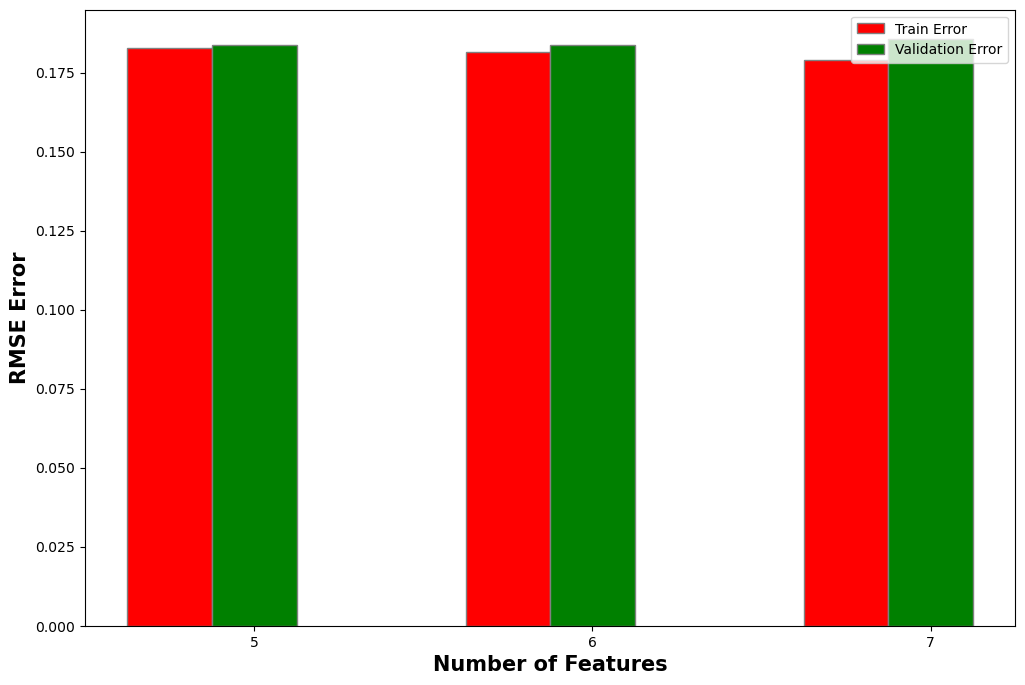

In [65]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(train_error))
br2 = [x + barWidth for x in br1]
plt.bar(br1, train_error, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Error')
plt.bar(br2, validation_error, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Error')
plt.xlabel('Number of Features', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE Error', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_error))],
        ['5', '6', '7'])
 
plt.legend()
plt.show()

In [66]:
pca1 = PCA_impl(n_components=4,random_state=True,standardize=True)
X_new = pca1.fit_transform(X,y)

In [68]:
target_df = pd.DataFrame(X_new, columns=['pc1','pc2','pc3','pc4'])
numbers=df['income'].to_numpy()
target_df['income'] = pd.Series(numbers, index=target_df.index)
df_train,df_test=train_test_split(target_df)
X_train,y_train=dataset_split(df_train)
X_test,y_test=dataset_split(df_test)
for column in X_train:
    X_train[column] = (X_train[column] - X_train[column].mean()) / X_train[column].std()
for column in X_test:
    X_test[column] = (X_test[column] - X_test[column].mean()) / X_test[column].std()

In [73]:
clf = DecisionTree(max_depth=10)
clf.fit(X_train.to_numpy(), y_train.to_numpy())

y_pred = clf.predict(X_test.to_numpy())
acc = accuracy(y_test.to_numpy(), y_pred)

In [74]:
print(acc)
print(np.square(np.subtract(y_test.to_numpy(),y_pred)).mean())
validation_error.append(np.square(np.subtract(y_test.to_numpy(),y_pred)).mean())
y_pred = clf.predict(X_train.to_numpy())
print(np.square(np.subtract(y_train.to_numpy(),y_pred)).mean())
train_error.append(np.square(np.subtract(y_train.to_numpy(),y_pred)).mean())

0.8136963865288156
0.18630361347118435
0.16261868809663962


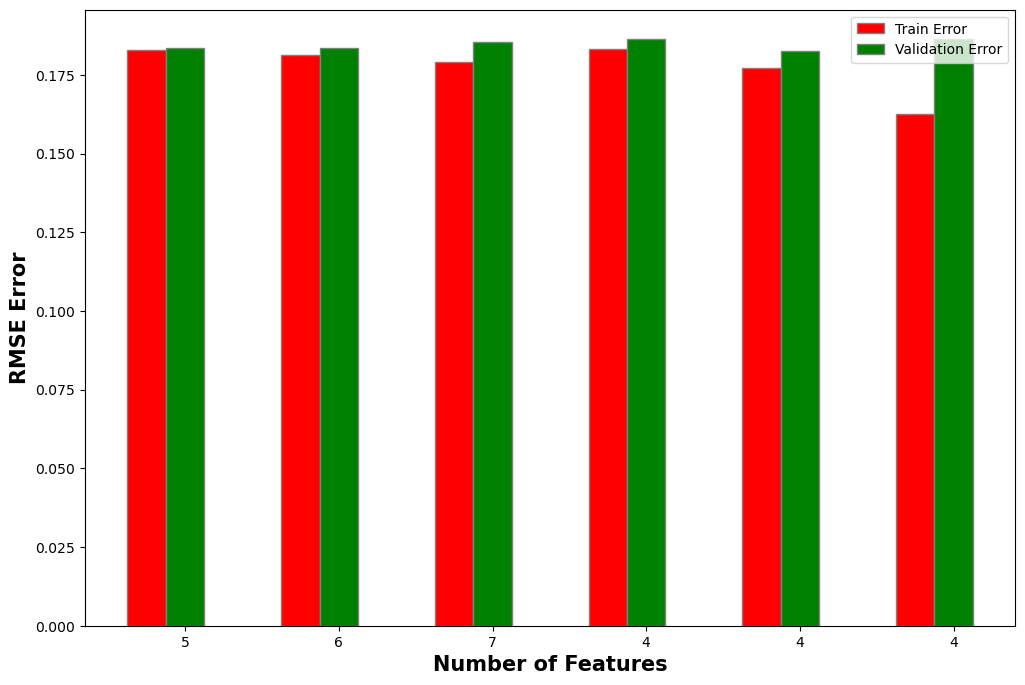

In [78]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(train_error))
br2 = [x + barWidth for x in br1]
plt.bar(br1, train_error, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train Error')
plt.bar(br2, validation_error, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation Error')
plt.xlabel('Number of Features', fontweight ='bold', fontsize = 15)
plt.ylabel('RMSE Error', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(train_error))],
        ['5', '6', '7','4','4','4'])
 
plt.legend()
plt.show()

### 3.3 Comment: